<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/OA_RS_Line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

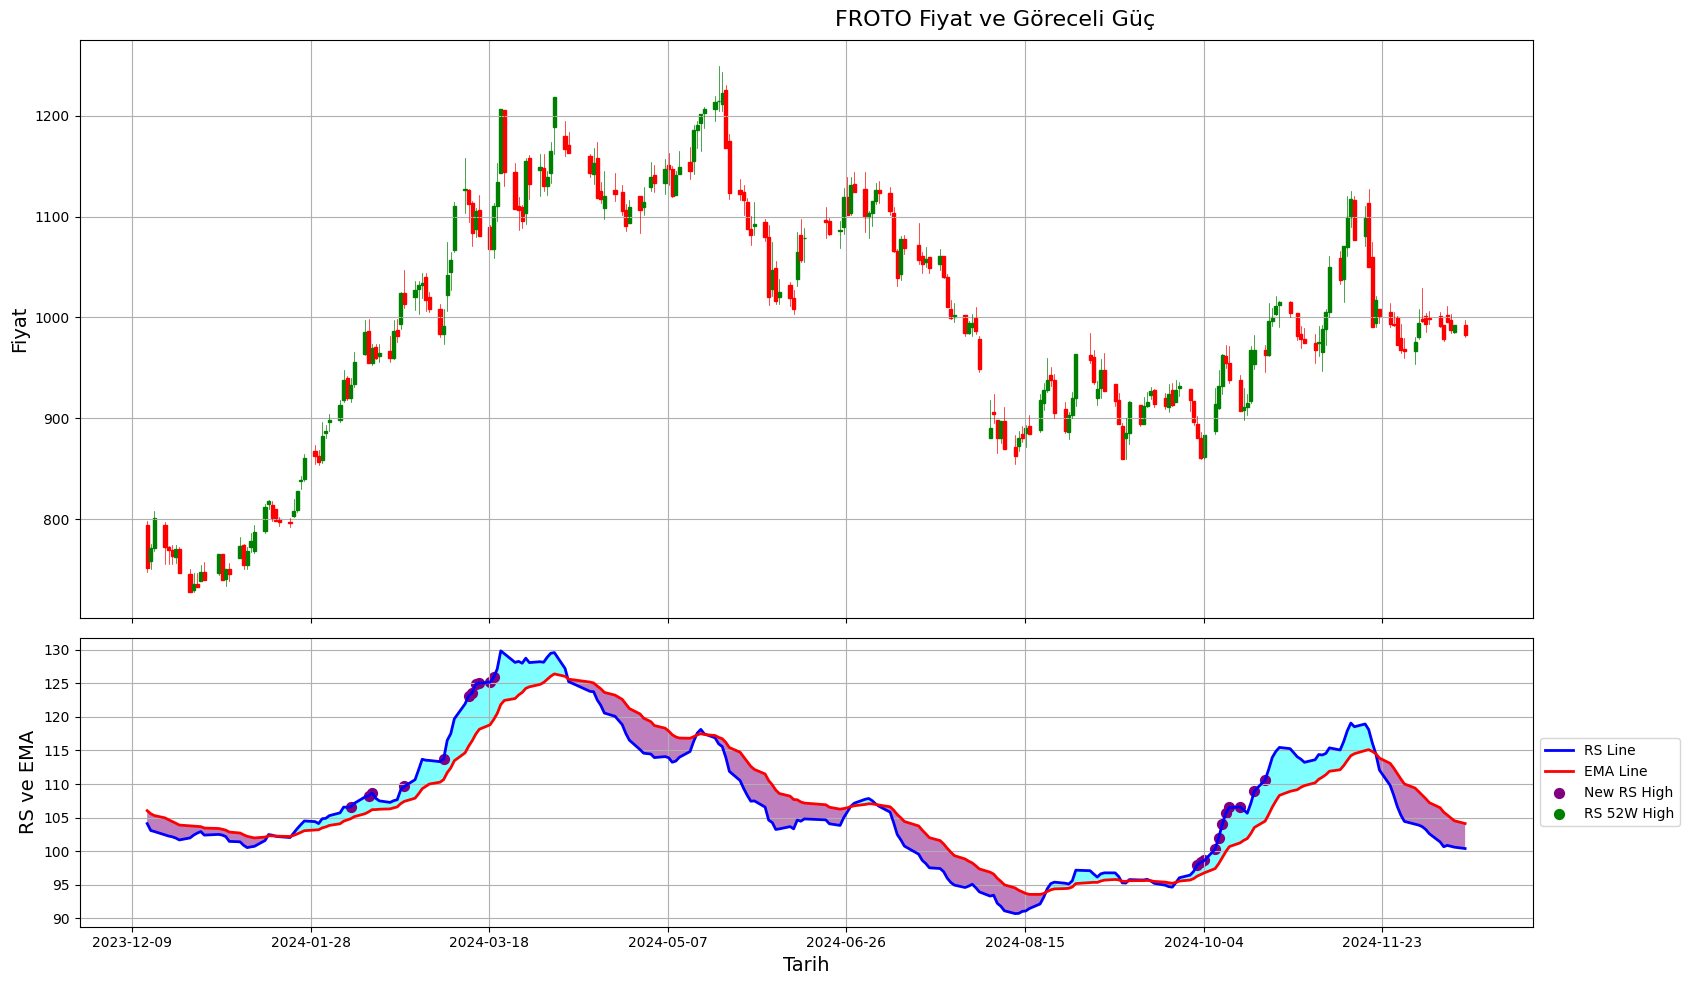

In [ ]:
# KÜTÜPHANELERİ YÜKLEME VE ÇAĞIRMA
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
try:
  import ta
  import yfinance as yf
  import mplfinance as mpf
  from mplfinance.original_flavor import candlestick_ohlc
  from tvDatafeed import TvDatafeed, Interval
  from tradingview_screener import get_all_symbols
  import logging
  logging.getLogger('tvDatafeed.main').setLevel(logging.ERROR)
except ModuleNotFoundError:
  subprocess.run(["pip", "install", "git+https://github.com/rongardF/tvdatafeed", "--quiet"])
  subprocess.run(["pip", "install", "tradingview-screener", "--quiet"])
  subprocess.run(["pip", "install", "mplfinance", "--quiet"])
  subprocess.run(["pip", "install", "yfinance==0.2.44", "--quiet"])
  subprocess.run(["pip", "install", "ta", "--quiet"])
  import ta
  import yfinance as yf
  import mplfinance as mpf
  from mplfinance.original_flavor import candlestick_ohlc
  from tvDatafeed import TvDatafeed, Interval
  from tradingview_screener import get_all_symbols
  import logging
  logging.getLogger('tvDatafeed.main').setLevel(logging.ERROR)

# HİSSE VE PARAMETRE SEÇİMİ
hisse = "FROTO"
endeks = "XU100"
interval = Interval.in_daily
ema_length = 21
lookback_count = 30

# HİSSE VE ENDEKS VERİLERİNİ ÇEKME
tv = TvDatafeed()
hisseData = tv.get_hist(symbol=hisse,exchange='BIST',interval=interval,n_bars=5000)
hisseData.rename(columns = {'symbol':'Symbol', 'open':'Open', 'high':'High','low':'Low','close':'Close','volume':'Volume'}, inplace = True)
endeksData = tv.get_hist(symbol=endeks,exchange='BIST',interval=interval,n_bars=5000)
endeksData.rename(columns = {'symbol':'Symbol', 'open':'Open', 'high':'High','low':'Low','close':'Close','volume':'Volume'}, inplace = True)

# NORMALİZASYON
hisseData['comp_base'] = endeksData['Close'].iloc[-1]
hisseData['current_base'] = hisseData['Close'].iloc[-1]
hisseData['comp_change'] = endeksData['Close'] / hisseData['comp_base'] * 100
hisseData['current_change'] = hisseData['Close'] / hisseData['current_base'] * 100

# GÖRECELİ GÜÇ ORANI HESAPLAMA
hisseData['base_rat'] = hisseData['current_change'] / hisseData['comp_change'] * 100
# GÖRECELİ GÜÇ ORANININ EMA'SINI ALMA
hisseData['RSLine'] = ta.trend.EMAIndicator(hisseData['base_rat'], window=5).ema_indicator()
hisseData['emaLine'] = ta.trend.EMAIndicator(hisseData['base_rat'], window=ema_length).ema_indicator()
# YENİ ZİRVELERE KARAR VERME (GERİYE BAKILACAK GÜN SAYISINA GÖRE)
hisseData['newRSHighSignal'] = hisseData['RSLine'] == hisseData['RSLine'].rolling(window=lookback_count).max()
hisseData['newPriceHighSignal'] = hisseData['Close'] == hisseData['Close'].rolling(window=lookback_count).max()
# 52 HAFTALIK ZİRVELERİ KONTROL ET
hisseData['rs52WHigh'] = hisseData['RSLine'].rolling(window=252).max()
hisseData['newRS52WHighSignal'] = hisseData['RSLine'] == hisseData['rs52WHigh']

# SON 252 VERİYE BAK (SENELİK VERİ)
data = hisseData.tail(252).copy()

### GRAFİK KISMI ###
data['Date'] = mdates.date2num(data.index.to_pydatetime())
ohlc = data[['Date', 'Open', 'High', 'Low', 'Close']]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle(f'{hisse} Fiyat ve Göreceli Güç', fontsize=16)

# 1. Grafik: Mum Grafiği
candlestick_ohlc(ax1, ohlc.values, width=0.9, colorup='green', colordown='red', alpha=1)
ax1.set_ylabel('Fiyat', fontsize=14)
ax1.grid(True)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))

# 2. Grafik: RS Line and EMA
ax2.plot(data.index, data['RSLine'], label='RS Line', color='blue', linewidth=2)
ax2.plot(data.index, data['emaLine'], label='EMA Line', color='red', linewidth=2)

# Çizgiler arasını doldur (RS Line and EMA Line)
ax2.fill_between(data.index, data['RSLine'], data['emaLine'], where=(data['RSLine'] >= data['emaLine']), facecolor='aqua', interpolate=True, alpha=0.5)
ax2.fill_between(data.index, data['RSLine'], data['emaLine'], where=(data['RSLine'] < data['emaLine']), facecolor='purple', interpolate=True, alpha=0.5)

# Yeni Göreceli Güç Tepesini Göster
newRSHighs = data[data['newRSHighSignal'] & ~data['newPriceHighSignal'] & ~data['newRS52WHighSignal']]
ax2.scatter(newRSHighs.index, newRSHighs['RSLine'], label='New RS High', color='purple', s=50, marker='o')
# 52W Zirve Göreceli Güç Noktalarını Göster
ax2.scatter(data[data['newRS52WHighSignal']].index, data[data['newRS52WHighSignal']]['RSLine'], label='RS 52W High', color='green', s=50, marker='o')

ax2.set_xlabel('Tarih', fontsize=14)
ax2.set_ylabel('RS ve EMA', fontsize=14)
ax2.grid(True)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
